# ทำนายผลผลิตข้าว โดยใช้ผลผลิตปีก่อน ๆ ด้วย Prophet

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd

import os
import itertools
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from fbprophet.plot import plot_plotly, plot_components_plotly

from utils.preproc import read_yield, read_annually_data, read_month_data, add_regressor
from utils.preproc import rice_inseason_harvest_season, rice_offseason_harvest_season, corn_harvest_season, cassava_harvest_season, rubber_harvest_season

py.init_notebook_mode(connected=True)

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Get data

In [2]:
params = {
    'rice_in-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปี.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปี.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
        'harvest' : rice_inseason_harvest_season,
        'n' : 35,
    },
    'rice_off-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปรัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปรัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
        'harvest' : rice_offseason_harvest_season,
        'n' : 35,
    },
    
    'corn': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวโพดเลี้ยงสัตว์.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวโพดเลี้ยงสัตว์.xlsx',
        'harvest' : corn_harvest_season,
        'n' : 20,
    },
    
    'palm': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตปาล์มน้ำมัน.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ปาล์มน้ำมัน.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาปาล์มน้ำมัน.xlsx',
        'harvest' : None,
        'n' : 20,
    },
    
    'cassava': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตมันสำปะหลัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่มันสำปะหลัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคามันสำปะหลังสดคละ.xlsx',
        'harvest' : cassava_harvest_season,
        'n' : 20,
    },
    
    'rubber': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตยางพารา.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ยางพารา.xlsx',
        'price_file' : ['OAE-process/OAE-ราคาน้ำยางสดคละ.xlsx', 'OAE-process/OAE-ราคายางก้อน.xlsx', 'OAE-process/OAE-ราคายางแผ่นดิบชั้น3.xlsx'],
        'harvest' : rubber_harvest_season,
        'n' : 20,
    }
}

ptype = 'rubber'#'rice_off-season'#'corn'#'rice_in-season'
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
is_harvest_season = param['harvest']
N = param['n']

In [3]:
df, df_group = read_yield(yield_file)

In [4]:
f"Percentage of training data: {df_group[:N]['value'].sum() / df_group['value'].sum():.3f}"

'Percentage of training data: 0.842'

In [5]:
df_group[:N]

,value
area,
Surat Thani,1150749
Songkhla,864855
Nakhon Si Thammarat,794399
Trang,617323
Yala,515290
Narathiwat,394947
Phatthalung,382636
Bueng Kan,341768
Phangnga,285405


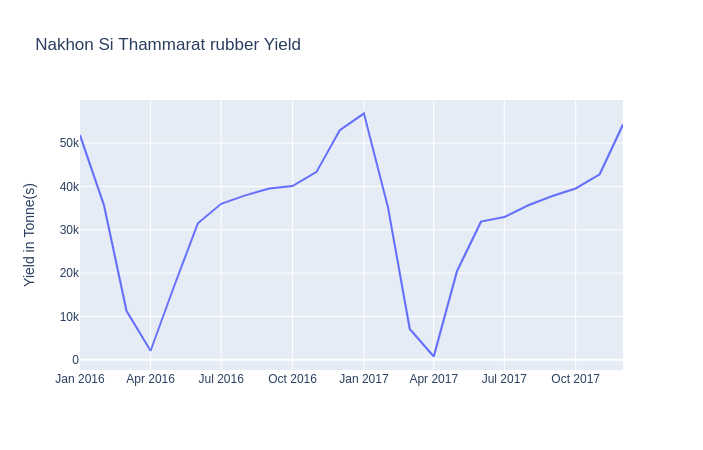

In [6]:
# area = df_group.iloc[N-1].name
area = df_group.iloc[2].name
_, _, df_area = read_yield(yield_file, area)

py.iplot({'data':go.Scatter(x=df_area['ds'], y=df_area['y'], name='y'),
         'layout':dict(title = area + " " + ptype + ' Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

Util functions

In [7]:
df_cost = read_annually_data(cost_file)

precipitation_file = 'OAE-process/OAE-ปริมาณน้ำฝน-ฝนตก.xlsx'
df_precipitation = read_month_data(precipitation_file, area)

if ptype == 'rubber':
    df_price1 = read_month_data(price_file[0])
    df_price2 = read_month_data(price_file[1])
    df_price3 = read_month_data(price_file[2])
    
    col_regressor = ['cost', 'precipitation', 'price_latex', 'price_cup', 'price_sheet']
    @add_regressor([df_cost, df_precipitation, df_price1, df_price2, df_price3], col_regressor)
    def add_features(df):
        return df
else:
    df_price = read_month_data(price_file)
    
    col_regressor = ['cost', 'precipitation', 'price']
    @add_regressor([df_cost, df_precipitation, df_price], col_regressor)
    def add_features(df):
        return df

### Grid Search Parameters

In [8]:
param_grid = {
#     'changepoint_prior_scale': [0.005, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'fourier_order': [3, 5, 7],
    'prior_scale': [0.1, 1, 5]
}

Generate all combinations of parameters

In [9]:
df_params = pd.DataFrame([dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())])
df_params

,seasonality_prior_scale,fourier_order,prior_scale
0,0.1,3,0.1
1,0.1,3,1.0
2,0.1,3,5.0
3,0.1,5,0.1
4,0.1,5,1.0
5,0.1,5,5.0
6,0.1,7,0.1
7,0.1,7,1.0
8,0.1,7,5.0
9,1.0,3,0.1


# Tuning using Grid Search

In [10]:
def all_provinces_predict(arg, areas):
#     print(arg)
    res = pd.DataFrame(columns = ['RMSE', 'MAE', 'AnnualErr'],
                       index = areas) 
    for province in areas:
        _, _, df_province = read_yield(yield_file, province)
        rmse, mae, aerr = one_province_predict(df_province, arg)
        res.loc[province] = [rmse, mae, aerr] 
    return res

In [11]:
def one_province_predict(df_yield, arg):
    df_train, df_test = df_yield[12:], df_yield[:12]
    
    df_train = add_features(df_train).dropna()
    
    
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    if 'seasonality_prior_scale' in arg:
        model.seasonality_prior_scale = arg['seasonality_prior_scale']
    if 'changepoint_prior_scale' in arg:
        model.changepoint_prior_scale = arg['changepoint_prior_scale']
    if 'holidays_prior_scale' in arg:
        model.holidays_prior_scale = arg['holidays_prior_scale']
    
    if is_harvest_season:
        df_train = df_train.apply(is_harvest_season, axis=1)    
        model.add_seasonality(name='monthly_harvest_season', 
                              period=30.5, 
                              fourier_order=int(arg['fourier_order']),
                              condition_name='harvest_season')
        
    for col in col_regressor:
        if 'prior_scale' in arg:
            model.add_regressor(col, 
                                prior_scale=arg['prior_scale'], 
                                mode='multiplicative')
        else:
            model.add_regressor(col, 
                                mode='multiplicative')

    model.fit(df_train)

    future = model.make_future_dataframe(periods=12, freq="MS")
    future = add_features(future)
    if is_harvest_season:
        future = future.apply(is_harvest_season, axis=1)

    forecast = model.predict(future)
    forecast.yhat.clip(lower=0, inplace=True)
    forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])
    
    # Sanity check that we are evaluating the forecase at the same date
    assert(np.all(forecast[:12]['ds'].to_numpy() == df_test['ds'].to_numpy()))
    # Calculate root mean squared error.
    rmse = np.sqrt(np.mean((forecast[:12]['yhat'].to_numpy() - df_test['y'].to_numpy())**2))
#     print('RMSE: %f' % rmse )
    mae = np.mean(np.abs(forecast[:12]['yhat'].to_numpy() - df_test['y'].to_numpy()))
#     print('MAE: %f' % mae )
    
    total_error = abs(1 - (np.sum(forecast[:12]['yhat'].to_numpy()) / np.sum(df_test['y'].to_numpy()))) * 100
#     print('Total Error: %.3f' % total_error)
#     print('Forecast:', np.sum(forecast[:12]['yhat'].to_numpy()))
#     print('Ground Truth:', np.sum(df_test['y'].to_numpy()))
    return rmse, mae, total_error

In [12]:
# res = df_params.progress_apply(lambda x: all_provinces_predict(x, df_group.index[:N]), axis=1)
%time res = df_params.parallel_apply(lambda x: all_provinces_predict(x, df_group.index[:N]), axis=1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_sea

CPU times: user 875 ms, sys: 402 ms, total: 1.28 s
Wall time: 1min 36s


Get overall results

In [13]:
overview = df_params.merge(pd.concat([t.mean() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

Save result to Excel file

In [14]:
os.makedirs('./outputs/', exist_ok = True)

with pd.ExcelWriter('./outputs/' + ptype + '_output.xlsx') as writer:
    overview.to_excel(writer, sheet_name='overview')
    for i,t in enumerate(res):
        t.to_excel(writer, sheet_name=f'{i}')  

In [15]:
overview

,seasonality_prior_scale,fourier_order,prior_scale,RMSE,MAE,AnnualErr
0,0.1,3,0.1,9834.481191,8355.570436,53.261484
1,0.1,3,1.0,12334.089057,10513.481609,62.959636
2,0.1,3,5.0,12280.776043,10500.756457,61.589017
3,0.1,5,0.1,14942.530588,13154.552741,83.839556
4,0.1,5,1.0,14653.694563,12974.260676,71.983966
5,0.1,5,5.0,15368.565665,13599.737021,76.461198
6,0.1,7,0.1,15811.123179,14031.767073,88.737456
7,0.1,7,1.0,14819.142094,13177.803072,72.024985
8,0.1,7,5.0,16261.970876,14442.203550,85.512943
9,1.0,3,0.1,17409.304959,15347.952333,102.417241
